In [3]:
#Import libraries
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from web3 import Web3
from tqdm import tqdm
from dotenv import load_dotenv
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
# Load .env file
load_dotenv()

# Load API key from .env file
api_key = os.getenv("ALCHEMY_API_KEY")


### Step 1: Set Up Web3 Connection

In [5]:
# Define the Alchemy API endpoint
api_endpoint = f"https://eth-mainnet.g.alchemy.com/v2/{api_key}"

# Set up Web3 connection
w3 = Web3(Web3.HTTPProvider(api_endpoint))

# Check if the connection is successful
if w3.isConnected():
    print("Connected to Ethereum node.")
else:
    print("Connection failed!")

Connected to Ethereum node.


In [6]:
# Define the start and end dates for which the data is required
start_date = datetime(2022, 5, 19)
end_date = datetime(2023, 5, 19)

# Step 2: Estimate the number of blocks per hour and total blocks for the time period

In [7]:
# Alternative to calculate average block time
# Get the number of the latest block
# latest_block_number = w3.eth.get_block('latest')['number']
# # Calculate the block times of the latest 1000 blocks
# block_times = []
# for i in range(1000):
#     # Get the current and previous blocks
#     current_block = w3.eth.get_block(latest_block_number - i)
#     previous_block = w3.eth.get_block(latest_block_number - i - 1)
    
#     # Calculate the block time and append to the list
#     block_time = current_block['timestamp'] - previous_block['timestamp']
#     block_times.append(block_time)

# # Calculate the average block time
# average_block_time = sum(block_times) / len(block_times)
# print(f"Average block time: {average_block_time} seconds")

# Define the block time(in seconds)
avg_block_time = 13  
print(f"Average block time: {avg_block_time} seconds")

# Calculate the estimated number of blocks per hourn(3600 seconds in an hour)
blocks_per_hour = int(3600 / avg_block_time)
print(f"Estimated blocks per hour: {blocks_per_hour}")

# Calculate the total hours for the given time period
total_hours = int((end_date - start_date).total_seconds() / 3600)

# Calculate the total number of blocks for the given time period
total_blocks = total_hours * blocks_per_hour
print(f"Total number of hourly blocks for the given time period: {total_blocks}")

Average block time: 13 seconds
Estimated blocks per hour: 276
Total number of hourly blocks for the given time period: 2417760


### Step 3: Fetch the gas prices and save them in a pandas DataFrame
In this step, we iterate through all the blocks within our determined range, fetch the block details, and extract the gas prices and timestamps. The gas price, initially in hexadecimal format ('baseFeePerGas'), is converted into an integer using `int(block['baseFeePerGas'], 16)`. For each block, a new DataFrame is created to store the gas price and timestamp. We use `pandas.concat()` to combine these new DataFrames with our main `gas_price_data` DataFrame.

The base fee per gas is typically represented as a hexadecimal number in the block information, so it is being converted to an integer using the int() function with base 16.
The gas prices obtained are in "wei", which is the smallest denomination of ether.

For perspective:
1 Ether (ETH) = 1,000,000,000,000,000,000 Wei (1e18 Wei)

In [280]:
# Get the latest block number
latest_block = w3.eth.block_number

In [281]:
# Calculate the start block
start_block = latest_block - total_blocks
start_block

14908416

In [282]:
# Initialize an empty DataFrame to store the gas prices
gas_price_data = pd.DataFrame(columns=['timestamp', 'gas_price'])

# Loop through the blocks, show status bar
for block_number in tqdm(range(start_block, latest_block, blocks_per_hour),
                         desc="Fetching gas prices data"): 
    
    # Get the block details
    block = w3.eth.get_block(block_number)

    # Convert the gas price from hex to integer
    gas_price = int(str(block['baseFeePerGas']), 16)

    # Convert timestamp to datetime and create a DataFrame with the block timestamp and gas price
    block_data = pd.DataFrame({
        'timestamp': [datetime.fromtimestamp(block['timestamp'])],
        'gas_price': [gas_price]
    })

    # Append the block data to the gas price data DataFrame
    gas_price_data = pd.concat([gas_price_data, block_data])

Fetching gas prices data:   0%|          | 27/8760 [00:05<27:02,  5.38it/s]


KeyboardInterrupt: 

In [342]:
gas_price_data = pd.read_csv('resources/gas_price_data_1year.csv')

In [343]:
# Save the DataFrame to a CSV file
gas_price_data.to_csv('resources/gas_price_data.csv', index=False)

In [344]:
gas_price_data.head()

,timestamp,gas_price
0,2022-06-01 11:03:52,63239618198
1,2022-06-01 12:03:48,68281963048
2,2022-06-01 13:08:25,121007946512
3,2022-06-01 14:07:45,126156205023
4,2022-06-01 15:10:50,67510279000


In [345]:
# Set `timestamp` column as index, copy DataFrame
gas_price_df = gas_price_data.set_index('timestamp').copy()

In [346]:
gas_price_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 2022-06-01 11:03:52 to 2023-05-20 15:50:35
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   gas_price  8760 non-null   int64
dtypes: int64(1)
memory usage: 136.9+ KB


In [347]:
display(gas_price_df.head(40))
gas_price_df.tail(10)

,gas_price
timestamp,
2022-06-01 11:03:52,63239618198
2022-06-01 12:03:48,68281963048
2022-06-01 13:08:25,121007946512
2022-06-01 14:07:45,126156205023
2022-06-01 15:10:50,67510279000
2022-06-01 16:15:23,32404767035
2022-06-01 17:18:36,31681542751
2022-06-01 18:28:45,63240093401
2022-06-01 19:33:58,41244724759


,gas_price
timestamp,
2023-05-20 07:26:23,36167651916
2023-05-20 08:22:11,42579332023
2023-05-20 09:17:47,36887580795
2023-05-20 10:13:23,42755192159
2023-05-20 11:09:35,34687802687
2023-05-20 12:05:35,29684795277
2023-05-20 13:02:35,31417792342
2023-05-20 13:58:35,31031853696
2023-05-20 14:54:23,28188597658


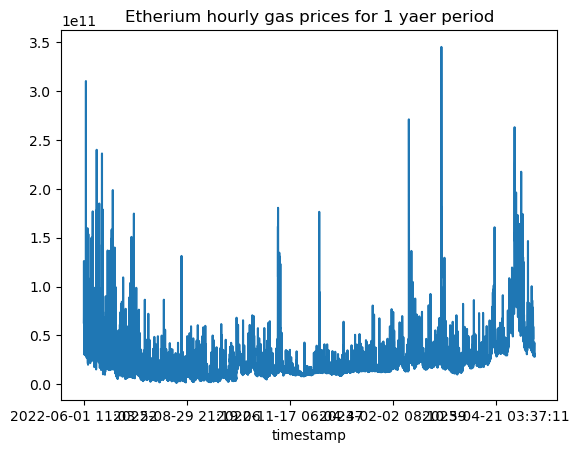

In [348]:
gas_price_df['gas_price'].plot(
    title="Etherium hourly gas prices for 1 yaer period");

### Step 4:Resample to daily data
The format 6.007497e+10 is scientific notation, and it is equivalent to 60,074,970,000. Scientific notation is often used for very large or very small numbers to make them easier to read and write.

In [349]:
gas_price_df.index = pd.to_datetime(gas_price_df.index)

# Resample the data into daily data, taking the mean gas price for each day
daily_gas_price_df = gas_price_df.resample('D').mean()
daily_gas_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 354 entries, 2022-06-01 to 2023-05-20
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gas_price  354 non-null    float64
dtypes: float64(1)
memory usage: 5.5 KB


In [350]:
display(daily_gas_price_df.head(20))
daily_gas_price_df.tail(10)

,gas_price
timestamp,
2022-06-01,6.007497e+10
2022-06-02,5.982783e+10
2022-06-03,6.758136e+10
2022-06-04,5.059850e+10
2022-06-05,5.107946e+10
2022-06-06,4.686028e+10
2022-06-07,5.828740e+10
2022-06-08,6.450062e+10
2022-06-09,5.889821e+10


,gas_price
timestamp,
2023-05-11,9.650878e+10
2023-05-12,5.662023e+10
2023-05-13,3.934500e+10
2023-05-14,4.242398e+10
2023-05-15,6.041061e+10
2023-05-16,5.258804e+10
2023-05-17,5.147708e+10
2023-05-18,5.086370e+10
2023-05-19,4.182389e+10


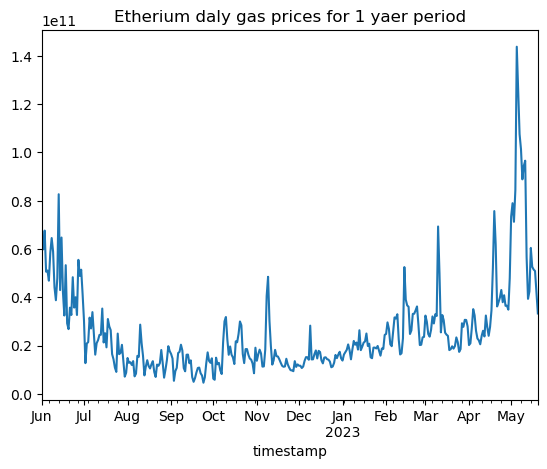

In [351]:
daily_gas_price_df['gas_price'].plot(
    title="Etherium daly gas prices for 1 yaer period");

### Step 6: Check for Stationarity
Before applying an ARIMA model, we need to make sure our data is stationary. The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.
This function will print out the test statistic, p-value, and critical values for the test. If the test statistic is less than the critical value, we can reject the null hypothesis (that the time series is not stationary). If not, we will need to transform the data to make it stationary.

In [352]:
display(daily_gas_price_df.tail(20))
daily_gas_price_df.info()

,gas_price
timestamp,
2023-05-01,7.341860e+10
2023-05-02,7.892379e+10
2023-05-03,7.122593e+10
2023-05-04,8.438872e+10
2023-05-05,1.436768e+11
2023-05-06,1.259894e+11
2023-05-07,1.074979e+11
2023-05-08,1.012665e+11
2023-05-09,8.879350e+10


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 354 entries, 2022-06-01 to 2023-05-20
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gas_price  354 non-null    float64
dtypes: float64(1)
memory usage: 5.5 KB


In [353]:
daily_gas_price_df.head()

,gas_price
timestamp,
2022-06-01,6.007497e+10
2022-06-02,5.982783e+10
2022-06-03,6.758136e+10
2022-06-04,5.059850e+10
2022-06-05,5.107946e+10


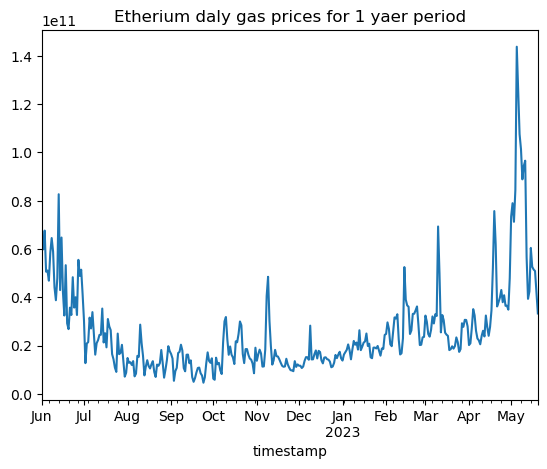

In [354]:
daily_gas_price_df['gas_price'].plot(
    title="Etherium daly gas prices for 1 yaer period");

In [355]:
adf_test = adfuller(daily_gas_price_df['gas_price'])
print(f'p-value: {adf_test[1]}')

p-value: 0.012721271931087587


In [356]:
# Define a function to perform the Augmented Dickey-Fuller test
def check_stationarity(data):
    """
    Perform Augmented Dickey-Fuller test to check for stationarity.
    
    Arguments:
    Pandas Series: a series of data to be checked for stationarity.
    
    Returns:
    Prints test statistics and critical values.
    """
    # Perform Augmented Dickey-Fuller test
    # Perform the test using the AIC criterion for choosing the number of lags
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test = adfuller(data, autolag='AIC')  

    # Extract and print the test statistics and critical values
    adf_output = pd.Series(adf_test[0:4], 
                           index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in adf_test[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)

daily_gas_price_df.to_csv('resources/daily_gas_price_df.csv', index=True)
# Apply the function
check_stationarity(daily_gas_price_df['gas_price'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.351663
p-value                          0.012721
#Lags Used                       3.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64


### Conclusion: 
Looking at your results:
* The Test Statistic (-3.35) is less than the 5% Critical Value (-2.869833).
* The p-value (0.012721) is less than 0.05.

The results allow us to reject the null hypothesis. Therefore, we conclude that the time series is stationary. This means that the statistical properties of the series (like the mean and variance) are not a function of time.

### Step 7: Plot ACF and PACF
The ACF and PACF plots are used to identify the parameters for the ARIMA model. For instance, a sharp drop after lag 'k' in the PACF plot indicates that 'k' should be the order of the AR term. Similarly, a gradual decline in the ACF plot suggests a MA term.
The `plot_acf` function plots the autocorrelation function, which measures the correlation between the time series with a lagged version of itself. The `lags` parameter specifies the number of lags to consider. The `zero` parameter is set to `False` to exclude the correlation of the time series with itself (at lag zero).

Similarly, the `plot_pacf` function plots the partial autocorrelation function. The PACF measures the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. In other words, it measures the direct effect of the past lagged observations on the current observation.

/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


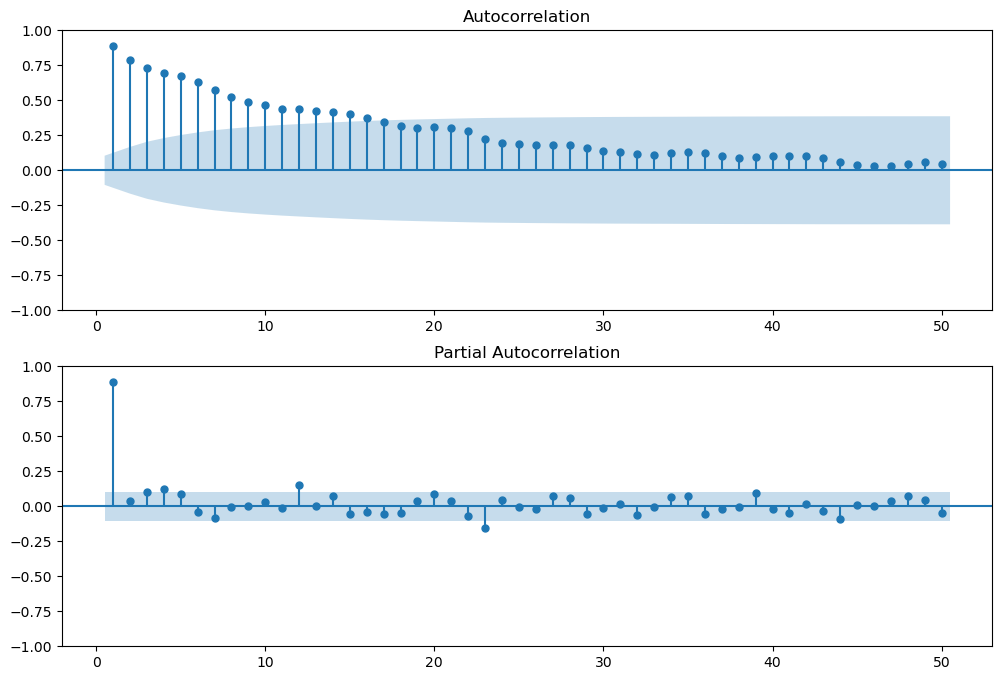

In [490]:
# Define the size of the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF on ax1
plot_acf(daily_gas_price_df['gas_price'], lags=50, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(daily_gas_price_df['gas_price'], lags=50, zero=False, ax=ax2)

# Show the plots
plt.show()

### Further Differencing and Transformation

Based on the results of the Augmented Dickey-Fuller (ADF) test, we can conclude that as the p-value is greater 0.05, and the test statistic is greater than the critical values. Therefore, we do not have enough evidence to reject the null hypothesis of non-stationarity. It suggests that the differenced series may still have some non-stationary components and further differencing or other transformations may be required to achieve stationarity.

In [491]:
# Original :
# Apply the function
check_stationarity(daily_gas_price_df['gas_price'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.351663
p-value                          0.012721
#Lags Used                       3.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64


Results of Augmented Dickey-Fuller Test:
Test Statistic                -7.775592e+00
p-value                        8.686908e-12
#Lags Used                     1.200000e+01
Number of Observations Used    3.400000e+02
Critical Value (1%)           -3.449730e+00
Critical Value (5%)           -2.870079e+00
Critical Value (10%)          -2.571319e+00
dtype: float64


/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


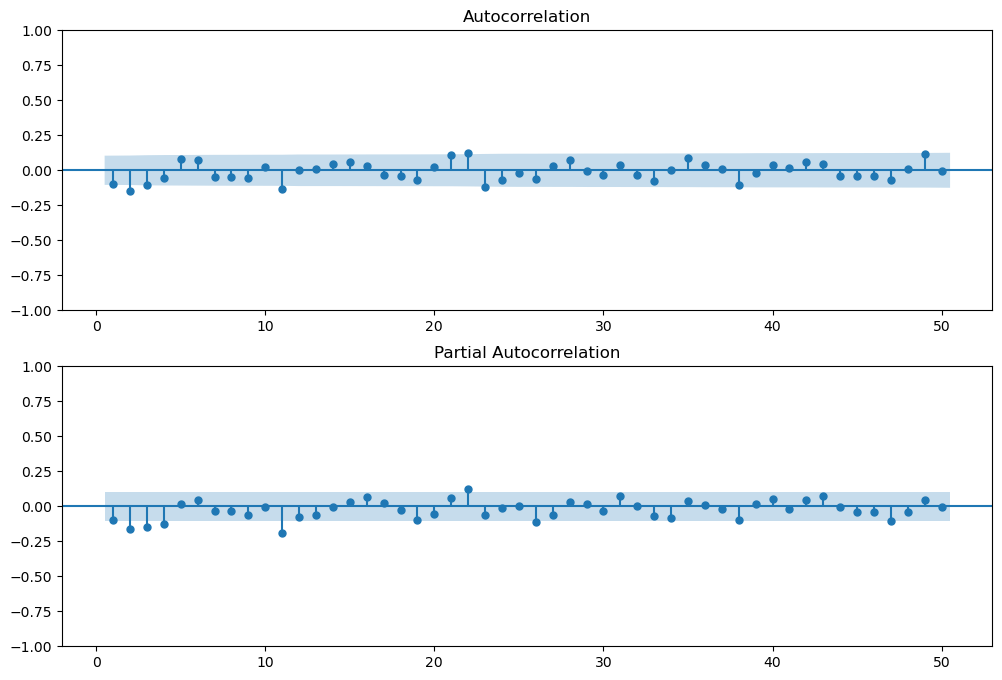

In [492]:
# 1: Technique 1: Simple Differencing
import pandas as pd

# Assuming your time series data is stored in a pandas DataFrame or Series
differenced_data_1 = daily_gas_price_df.diff(1).dropna()

# Check to see if the differenced data is stationary
check_stationarity(differenced_data_1['gas_price'])

# Define the size of the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF on ax1
plot_acf(differenced_data_1['gas_price'], lags=50, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(differenced_data_1['gas_price'], lags=50, zero=False, ax=ax2)

# Show the plots
plt.show()

Results of Augmented Dickey-Fuller Test:
Test Statistic                -7.671419e+00
p-value                        1.589916e-11
#Lags Used                     9.000000e+00
Number of Observations Used    3.380000e+02
Critical Value (1%)           -3.449846e+00
Critical Value (5%)           -2.870129e+00
Critical Value (10%)          -2.571346e+00
dtype: float64


/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


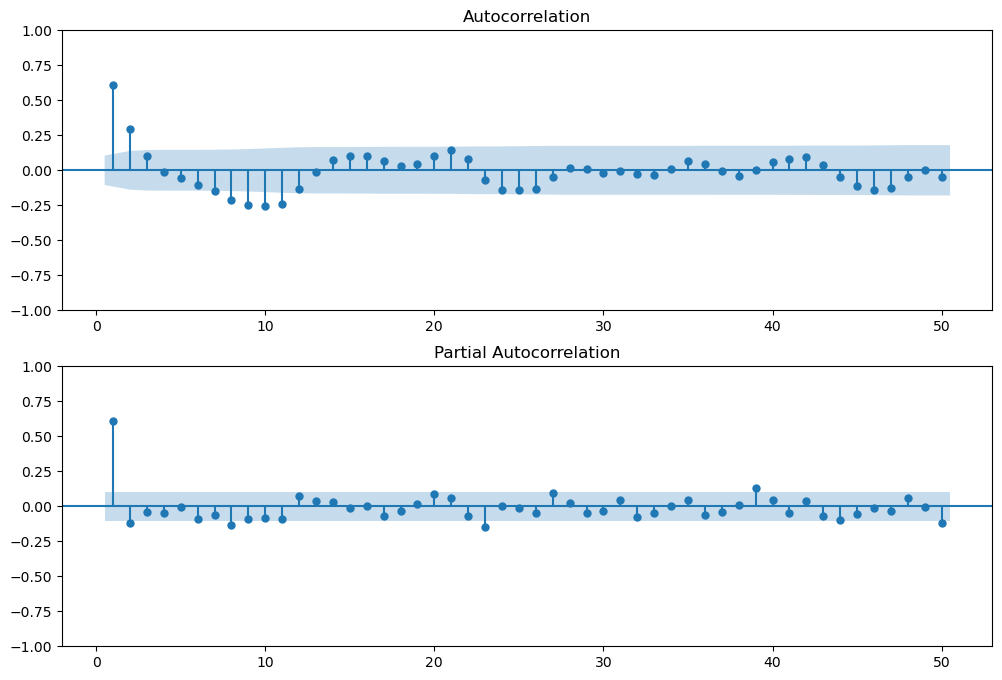

In [493]:
# 2: Rolling Mean Subtraction:
window_size = 7  # Adjust the window size as per your data frequency
rolling_mean = daily_gas_price_df.rolling(window=window_size).mean()
differenced_data_2 = daily_gas_price_df - rolling_mean
differenced_data_2 = differenced_data_2.dropna()

# Check to see if the differenced data is stationary
check_stationarity(differenced_data_2['gas_price'])


# Define the size of the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF on ax1
plot_acf(differenced_data_2['gas_price'], lags=50, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(differenced_data_2['gas_price'], lags=50, zero=False, ax=ax2)

# Show the plots
plt.show()

Results of Augmented Dickey-Fuller Test:
Test Statistic                -9.990899e+00
p-value                        1.997488e-17
#Lags Used                     1.200000e+01
Number of Observations Used    3.340000e+02
Critical Value (1%)           -3.450081e+00
Critical Value (5%)           -2.870233e+00
Critical Value (10%)          -2.571401e+00
dtype: float64


/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


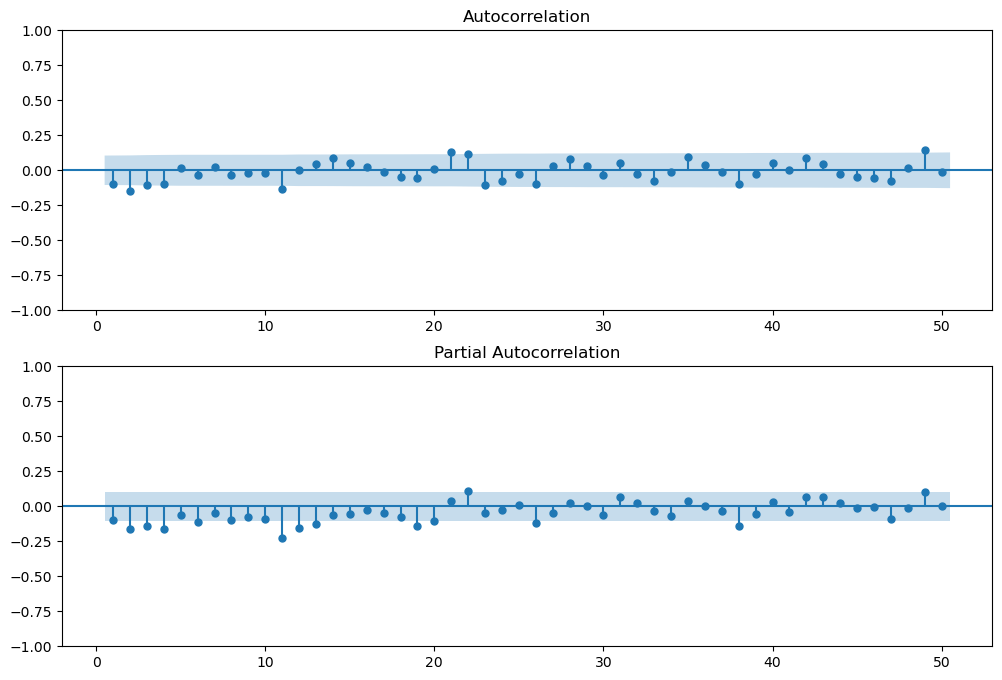

In [494]:
# 3.5 : Rolling Mean Subtraction + Differencing
window_size = 7  # Adjust the window size as per your data frequency
rolling_mean = differenced_data_1.rolling(window=window_size).mean()
differenced_data_3 = differenced_data_1 - rolling_mean
differenced_data_3 = differenced_data_3.dropna()

# Check to see if the differenced data is stationary
check_stationarity(differenced_data_3['gas_price'])


# Define the size of the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF on ax1
plot_acf(differenced_data_3['gas_price'], lags=50, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(differenced_data_3['gas_price'], lags=50, zero=False, ax=ax2)

# Show the plots
plt.show()


After running the above (3) transformations on the original data, we pair them together continuously, to try and find our optimal model. 

# EXTRA - Creating the Arima Model



In [495]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


## Using Grid Search and Bayesian Optimization to optimize the ARIMA model

when working with an ARIMA model, we must seperate the different components within our data. Of those components, are the AR component, the Differencing, and the Moving Average (MA). 

 The AR Component is found by looking for spikes in the partial autocorellation plot, or in other words by looking for the 'pin' that visually departs from baseline. In this case, it would be the first value. 
        - p = 1

### Visual Analysis
Based on visual analysis of the plots, it can be understood that in terms of an MA value, there is initially a strong correlation at lag 1, but this corellation continually dimishes, so that by lag 17 all subsequent values lie within the confidence interval. This would mean that as time goes on, there is less an less correlation between the two variables in the data we want to fit to the ARIMA model-- while there may have ben an initial correlation. There is potentially a moving average component, and we assume that starting with a low order MA component (q=2) and re-evaluating the model later will be the best choice. 

---

## Evaluation
To safely conclude which p, d, q pair will result in the optimal outcome, we must utilize objective testing mechanisms to find our optimal model makeup. 

I will try and use the Grid search technique, aswell as the bayesian optimization techniques to optimize the ARIMA model. 

# Grid Search Test:

In [496]:
import itertools
import statsmodels.api as sm
import numpy as np

In [534]:
# Choose which Data to test:
data = differenced_data_1['gas_price']
data_2 = differenced_data_2['gas_price']
data_3 = differenced_data_3['gas_price']
data_4 = daily_gas_price_df['gas_price']

# Convert the data to a dataframe
data = pd.DataFrame(data_2)

# display the first 5 rows of the data
display(data.head())
display(data.info())


,gas_price
timestamp,
2022-06-07,1.957427e+09
2022-06-08,7.538414e+09
2022-06-09,2.068809e+09
2022-06-10,-9.341761e+09
2022-06-11,-1.302202e+10


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 348 entries, 2022-06-07 to 2023-05-20
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gas_price  348 non-null    float64
dtypes: float64(1)
memory usage: 5.4 KB


None

<AxesSubplot:title={'center':'Daily Gas Prices - Data For Arima Model'}>

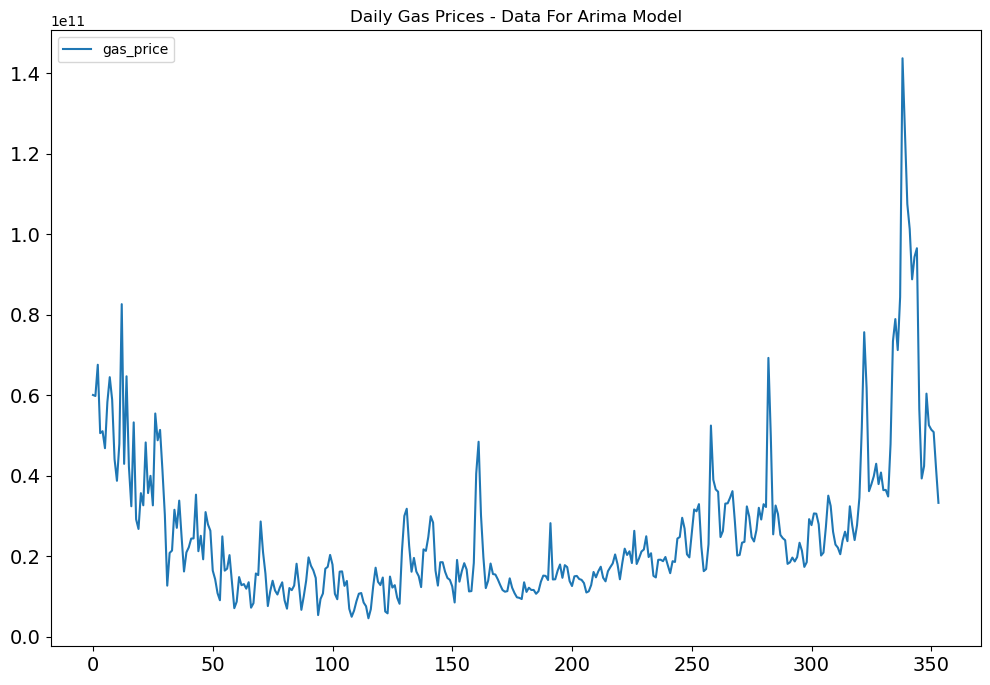

In [535]:
# show a plot of the data
daily_gas_price_df.plot(figsize=(12,8), title='Daily Gas Prices - Data For Arima Model', fontsize=14)

In [571]:
best_mse = float('inf')  # Initialize the best performance metrics
best_mae = float('inf')
best_rmse = float('inf')
best_aic = float('inf')

In [572]:

best_mse_model = None  # Initialize the best model variables
best_mae_model = None
best_rmse_model = None
best_aic_model = None



In [573]:
# Determine the index at which to split the data
split_index = int(len(data_4) * 0.8)  # Split at 80% of the data

# Split the data into train and test sets
train = data_4.iloc[:split_index]
test = data_4.iloc[split_index:]

In [574]:
# Define the ranges for p, d, and q values
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

In [575]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Choose the number of times to iterate over all p, d, and q values
num_tries = 5

# Iterate over all combinations of p, d, and q values, 50 times

for _ in range(num_tries):
    for p, d, q in itertools.product(p_values, d_values, q_values):
        
            # Fit ARIMA model with current combination of p, d, and q
            model = sm.tsa.ARIMA(train, order=(p, d, q))
            fitted_model = model.fit()

            # Calculate AIC
            aic = fitted_model.aic

            # Make predictions on the testing set
            predictions = fitted_model.predict(start=test.index[0], end=test.index[-1])

            # Evaluate the model's performance
            mse = mean_squared_error(test, predictions)
            mae = mean_absolute_error(test, predictions)
            rmse = np.sqrt(mse)

            if mse < best_mse:
                best_mse = mse
                best_mse_model = fitted_model
                best_mse_predictions = predictions

            if mae < best_mae:
                best_mae = mae
                best_mae_model = fitted_model
                best_mae_predictions = predictions
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_rmse_model = fitted_model
                best_rmse_predictions = predictions
            
            # Check if current model has lower AIC than the previous best model
            if aic < best_aic:
                best_aic = aic
                best_aic_model = fitted_model
                best_aic_predictions = predictions
                

# After the loop, you can access the best_model and best_aic variables
# which hold the results of the best-performing model across multiple tries

/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starti

In [576]:
display(print(f"Best model: {best_rmse_model.summary()}"))

Best model:                                SARIMAX Results                                
Dep. Variable:              gas_price   No. Observations:                  283
Model:                 ARIMA(0, 2, 3)   Log Likelihood               -6801.426
Date:                Tue, 23 May 2023   AIC                          13610.853
Time:                        21:10:31   BIC                          13625.406
Sample:                             0   HQIC                         13616.689
                                - 283                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.3552      0.045    -29.906      0.000      -1.444      -1.266
ma.L2          0.0771      0.043      1.776      0.076      -0.008       0.162
ma.L3          0.2781      0.038      7.

None

In [577]:
display(print("Mean Squared Error (MSE):", best_mse))
display(print("Mean Absolute Error (MAE):", best_mae))
display(print("Root Mean Squared Error (RMSE):", best_rmse))

Mean Squared Error (MSE): 7.105128885833981e+20


None

Mean Absolute Error (MAE): 19152364343.153893


None

Root Mean Squared Error (RMSE): 26655447634.27165


None

In [578]:
display(print("Best AIC Model: \n", best_aic_model.summary()))
display(print("Best MSE Model: \n", best_mse_model.summary()))
display(print("Best MAE Model: \n", best_mae_model.summary()))
display(print("Best RMSE Model: \n", best_rmse_model.summary()))

Best AIC Model: 
                                SARIMAX Results                                
Dep. Variable:              gas_price   No. Observations:                  283
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -6784.394
Date:                Tue, 23 May 2023   AIC                          13580.788
Time:                        21:10:32   BIC                          13602.640
Sample:                             0   HQIC                         13589.551
                                - 283                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6550      0.061     10.724      0.000       0.535       0.775
ar.L2         -0.6669      0.070     -9.594      0.000      -0.803      -0.531
ma.L1         -1.0576      0.072  

None

Best MSE Model: 
                                SARIMAX Results                                
Dep. Variable:              gas_price   No. Observations:                  283
Model:                 ARIMA(0, 2, 3)   Log Likelihood               -6801.426
Date:                Tue, 23 May 2023   AIC                          13610.853
Time:                        21:10:32   BIC                          13625.406
Sample:                             0   HQIC                         13616.689
                                - 283                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.3552      0.045    -29.906      0.000      -1.444      -1.266
ma.L2          0.0771      0.043      1.776      0.076      -0.008       0.162
ma.L3          0.2781      0.038  

None

Best MAE Model: 
                                SARIMAX Results                                
Dep. Variable:              gas_price   No. Observations:                  283
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -6791.259
Date:                Tue, 23 May 2023   AIC                          13592.519
Time:                        21:10:32   BIC                          13610.729
Sample:                             0   HQIC                         13599.821
                                - 283                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1789      0.128      1.399      0.162      -0.072       0.430
ma.L1         -0.5446      0.124     -4.393      0.000      -0.788      -0.302
ma.L2          0.0072      0.066  

None

Best RMSE Model: 
                                SARIMAX Results                                
Dep. Variable:              gas_price   No. Observations:                  283
Model:                 ARIMA(0, 2, 3)   Log Likelihood               -6801.426
Date:                Tue, 23 May 2023   AIC                          13610.853
Time:                        21:10:32   BIC                          13625.406
Sample:                             0   HQIC                         13616.689
                                - 283                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.3552      0.045    -29.906      0.000      -1.444      -1.266
ma.L2          0.0771      0.043      1.776      0.076      -0.008       0.162
ma.L3          0.2781      0.038 

None

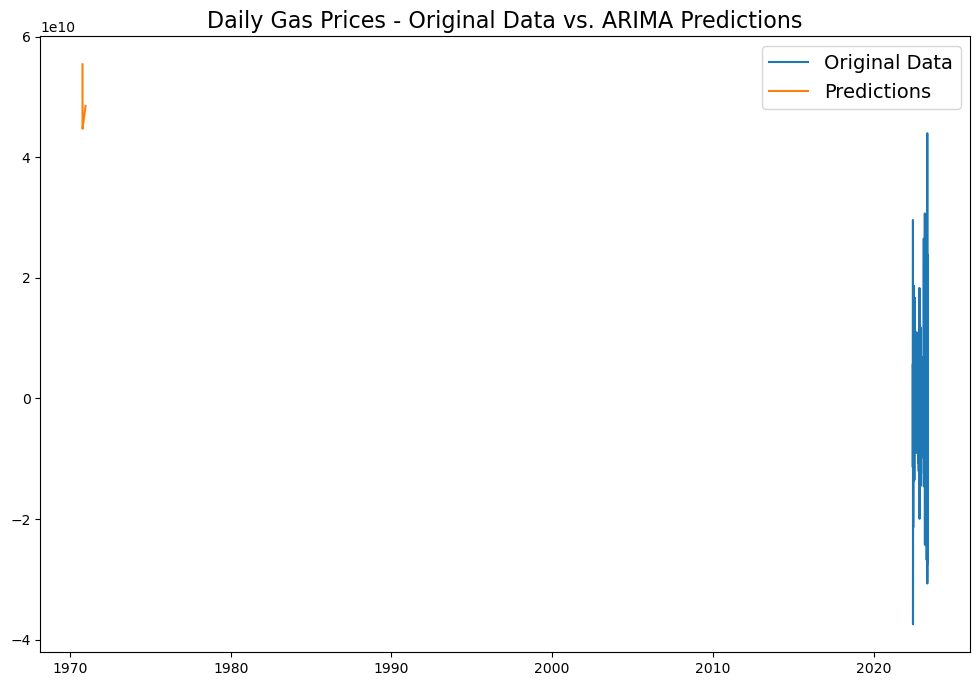

In [579]:
# Specify the desired data range
start_date = '2023-03-01'
end_date = '2023-05-20'

# Plot the original data, and the best rmse model's predictions
plt.figure(figsize=(12,8))
plt.plot(data_3, label='Original Data')
plt.plot(best_rmse_predictions, label='Predictions')
plt.title('Daily Gas Prices - Original Data vs. ARIMA Predictions', fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [580]:
# Print the best model and its AIC
display(print(f"Best ARIMA Model (Grid Search): {best_rmse_model.summary()}"))
display(print(f"Best AIC (Grid Search): {best_aic}"))
display(print("Root Mean Squared Error (RMSE):", best_rmse))

Best ARIMA Model (Grid Search):                                SARIMAX Results                                
Dep. Variable:              gas_price   No. Observations:                  283
Model:                 ARIMA(0, 2, 3)   Log Likelihood               -6801.426
Date:                Tue, 23 May 2023   AIC                          13610.853
Time:                        21:10:32   BIC                          13625.406
Sample:                             0   HQIC                         13616.689
                                - 283                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.3552      0.045    -29.906      0.000      -1.444      -1.266
ma.L2          0.0771      0.043      1.776      0.076      -0.008       0.162
ma.L3          0.278

None

Best AIC (Grid Search): 13580.788306216862


None

Root Mean Squared Error (RMSE): 26655447634.27165


None

In [581]:
daily_gas_price_df

,gas_price
0,6.007497e+10
1,5.982783e+10
2,6.758136e+10
3,5.059850e+10
4,5.107946e+10
...,...
349,5.258804e+10
350,5.147708e+10
351,5.086370e+10
352,4.182389e+10


### Visualizing Model Performance (Grid Search)


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

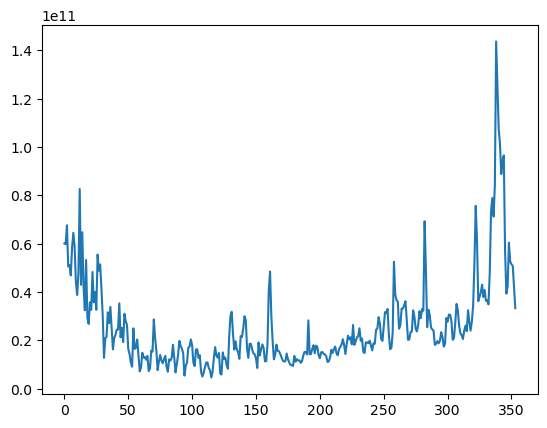

In [582]:
import matplotlib.pyplot as plt

start_date = '2023-01-01'
end_date = '2023-05-20'
# Plot actual values
plt.plot(daily_gas_price_df.index, daily_gas_price_df['gas_price'], label='Actual')
# Plot predicted values from the best model
predicted_values = best_rmse_model.predict(start=start_date, end=end_date)
plt.plot(predicted_values.index, predicted_values, label='Predicted')
# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
# Add legend
plt.legend()
# Show the plot
plt.show()

In [ ]:
# Compare the AIC of the best model from the grid search with the AIC of the model from the previous exercise
print("Best RMSE Model AIC:",  best_rmse_model.aic)



Best RMSE Model AIC: 13250.478514335127


# Bayesian Optimization:

In [583]:
# Define a function for the rolling forecast using ARIMA model
def arima_rolling_forecast(train, order, window_size=7):
    """
    Perform a rolling forecast using an ARIMA model with specified window size.
    Parameters:
    train (array-like): The training data.
    order (tuple): The order of the ARIMA model.
    window_size (int): The size of the rolling window.
    Returns:
    predictions (list): The forecasts for the test data.
    """
    predictions = []
    for i in range(0, len(train) - window_size):
        # Fit the ARIMA model on a window of data and make a one-step forecast
        window_data = train[i: i + window_size]
        model = ARIMA(window_data, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        # Add the forecast to the list of predictions
        predictions.append(yhat)
    return predictions, model, model_fit

/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/najibabounasr/opt/anaconda3/envs/dev/lib/python3.7/sit

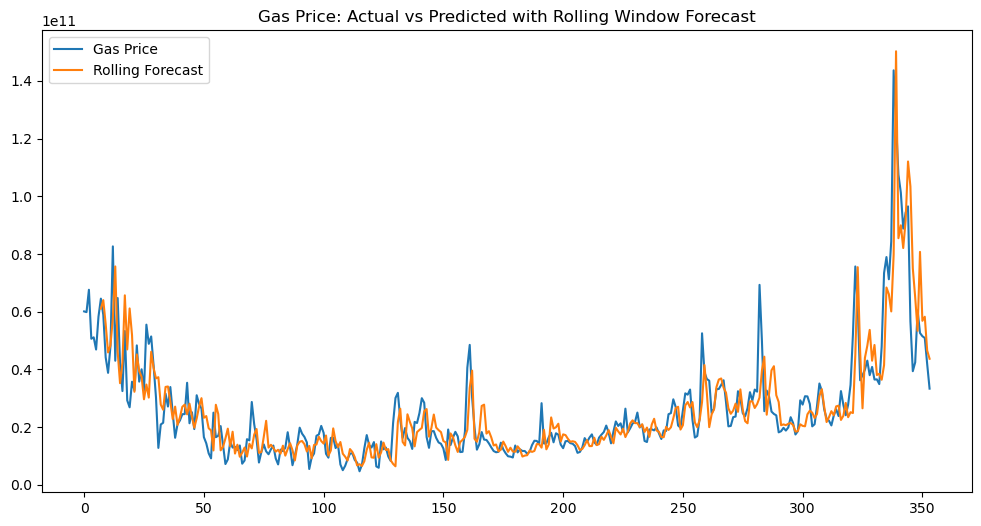

In [589]:
# Set the best order from the previous step
order = (3, 0, 3)
# Use the function to forecast the test data
rolling_forecast = arima_rolling_forecast(daily_gas_price_df['gas_price'].values, order, window_size=7)
# Add the rolling forecast to the DataFrame
daily_gas_price_df['rolling_forecast'] = None
daily_gas_price_df.loc[daily_gas_price_df.index[7:7+len(rolling_forecast)], 'rolling_forecast'] = rolling_forecast

# Then plot it
plt.figure(figsize=(12,6))
plt.plot(daily_gas_price_df.index, daily_gas_price_df['gas_price'], label='Gas Price')
plt.plot(daily_gas_price_df.index, daily_gas_price_df['rolling_forecast'], label='Rolling Forecast')
plt.legend(loc='best')
plt.title('Gas Price: Actual vs Predicted with Rolling Window Forecast')
plt.show()

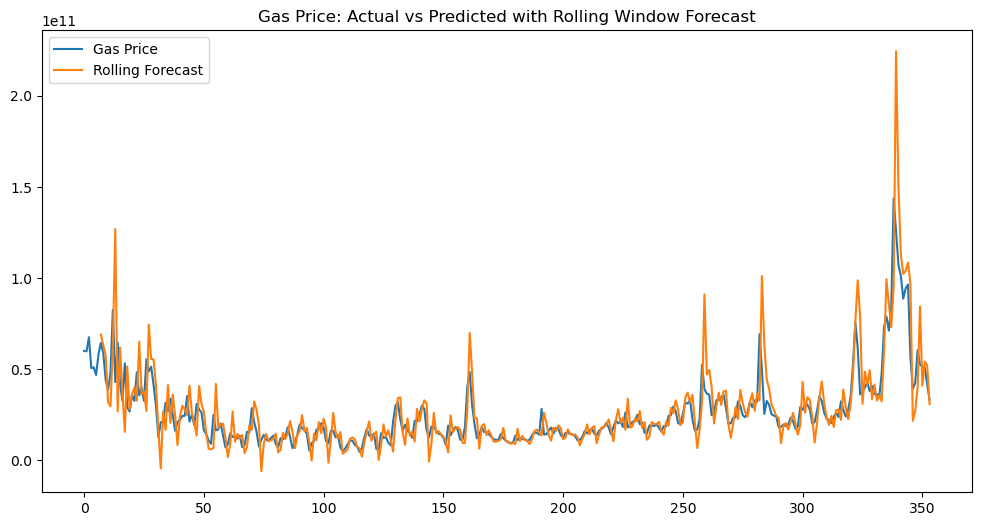

In [590]:
# Set the best order from the previous step
order = (0, 2, 2)
# Use the function to forecast the test data
rolling_forecast = arima_rolling_forecast(daily_gas_price_df['gas_price'].values, order, window_size=7)
# Add the rolling forecast to the DataFrame
daily_gas_price_df['rolling_forecast'] = None
daily_gas_price_df.loc[daily_gas_price_df.index[7:7+len(rolling_forecast)], 'rolling_forecast'] = rolling_forecast

# Then plot it
plt.figure(figsize=(12,6))
plt.plot(daily_gas_price_df.index, daily_gas_price_df['gas_price'], label='Gas Price')
plt.plot(daily_gas_price_df.index, daily_gas_price_df['rolling_forecast'], label='Rolling Forecast')
plt.legend(loc='best')
plt.title('Gas Price: Actual vs Predicted with Rolling Window Forecast')
plt.show()

In [591]:

# # Define a function to calculate MAPE
# def mean_absolute_percentage_error(y_true, y_pred):
#     """
#     Calculate Mean Absolute Percentage Error (MAPE).
#     Returns:
#     mape (float): The MAPE.
#     """
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# # Slice test['gas_price'].values and rolling_forecast to have the same size
# size = min(len(test['gas_price'].values), len(rolling_forecast))
# # Calculate MAPE for the rolling forecast
# mape = mean_absolute_percentage_error(test['gas_price'].values[:size], rolling_forecast[:size])
# print('The Mean Absolute Percentage Error for the rolling forecast is: ', mape)

KeyError: 'gas_price'